In [1]:
import torch
import load_dataset
import torchaudio
import torchaudio.functional as F
# load the cnn model with pytorch
path = 'models/model_base_2.ckpt'
model = load_dataset.CNN()
model.load_state_dict(torch.load(path))
# load the audio file
image = load_dataset.load_dataset('../../sound-propagation-simulation/dataset_real_data/v3/test/')
#image = load_dataset.load_dataset('patch-attack-data/')
img_number = 1
waveform = image['waveforms'][img_number]
label = image['labels'][img_number]

print('true',label,end=' prediction ')
int_to_labels = {0: 'no_car', 1: 'multiple_cars', 2: 'left_to_right', 3: 'right_to_left'}
labels_to_int = {'no_car': 0, 'multiple_cars': 1, 'left_to_right': 2, 'right_to_left': 3}
# convert the audio file to spectrogram
spectrogram = F.spectrogram(waveform, pad=0, window=torch.hann_window(1000), n_fft=1000, hop_length=1280, win_length=1000, power=2.0, normalized=True)
# add a dimension to the spectrogram
spectrogram = spectrogram.unsqueeze(0)
# predict the label
output = model(spectrogram)
# get the index of the highest value
a, predicted = torch.max(output[0], 1)
print(int_to_labels[predicted.item()], a)

waveforms = image['waveforms']

spectrograms = [F.spectrogram(waveform, pad=0, window=torch.hann_window(1000), n_fft=1000, hop_length=1280, win_length=1000, power=2.0, normalized=True).unsqueeze(0) for waveform in waveforms]
print(len(spectrograms))
labels = image['labels']
print(labels)

number of label: 4
true left_to_right prediction no_car tensor([1.0188], grad_fn=<MaxBackward0>)
610
['left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right

No attack label: 2 0.51 left_to_right
2
Attacked label: 2 0.54 left_to_right
2


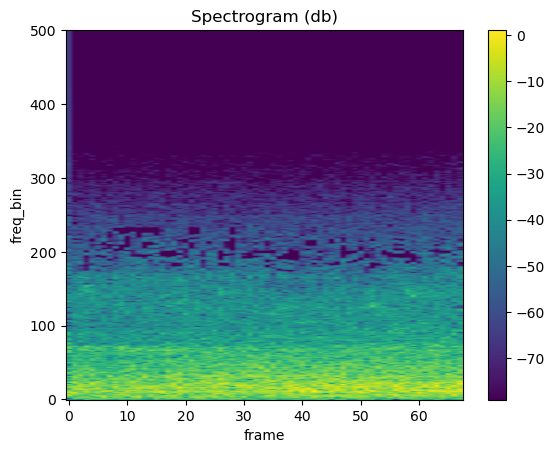

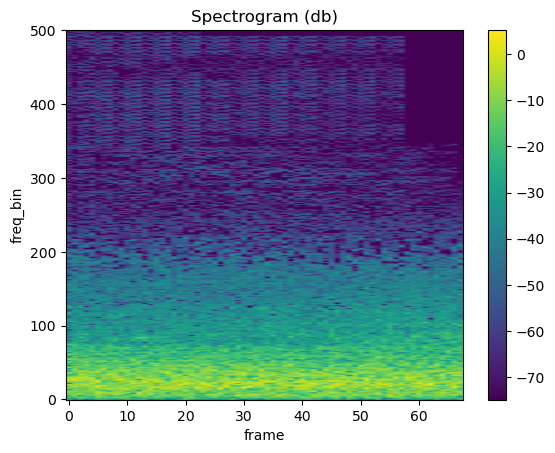

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Fast Gradient Sign Attack

# define the loss function
criterion = nn.CrossEntropyLoss()
epsilon = 0.01
input_tensor = spectrograms[0]
input_tensor.requires_grad = True
output = model(input_tensor)
a, predicted = torch.max(output[0], 1)
certainty = a.item()
loss = criterion(output[0], torch.tensor([3]))
loss.backward()

sign_data_grad = input_tensor.grad.sign()
perturbed_input_tensor = input_tensor + epsilon * input_tensor.grad
output = model(perturbed_input_tensor)
a, attacked_predicted = torch.max(output[0], 1)
attacked_certainty = a.item()
print('No attack label:', predicted.item(), round(certainty,2), int_to_labels[predicted.item()])
print(predicted.item())
print('Attacked label:', attacked_predicted.item(), round(attacked_certainty,2), int_to_labels[attacked_predicted.item()])
print(attacked_predicted.item())
# plot the base spectrogram and the perturbed spectrogram
load_dataset.plot_spectrogram(spectrogram.detach().numpy()[0][0])
load_dataset.plot_spectrogram(perturbed_input_tensor.detach().numpy()[0][0])

In [23]:
different_dict = {}
scores = {}
import numpy as np
from tqdm import tqdm
import random
steps = 10
l = np.geomspace(1e-8,1e1,steps)
plots_base = []
label_base = []
plots_perturbed = []
label_perturbed = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

for j in l:
    total = 0
    same,score = 0,0
    already_saved = False
    for i in tqdm(range(len(spectrograms))):
        criterion = nn.CrossEntropyLoss()
        epsilon = j
        input_tensor = spectrograms[i]
        input_tensor.requires_grad = True
        input_tensor = input_tensor.to(device)
        input_tensor.retain_grad()
        
        output = model(input_tensor)
        _, predicted = torch.max(output[0], 1)

        model.zero_grad()
        loss = criterion(output[0], torch.tensor([labels_to_int[labels[i]]]).to(device))
        loss.backward()

        perturbed_input_tensor = input_tensor + epsilon * input_tensor.grad.sign()
        
        output = model(perturbed_input_tensor)
        _, attacked_predicted = torch.max(output[0], 1)
        
        total+=1
        if predicted.item() == attacked_predicted.item():
            same += 1
        if not already_saved:
            already_saved = True
            # add the base spectrogram and the perturbed spectrogram to the plots list
            plots_base.append(spectrogram.detach().numpy()[0][0])
            label_base.append(int_to_labels[predicted.item()])
            plots_perturbed.append(perturbed_input_tensor.cpu().detach().numpy()[0][0])
            label_perturbed.append(int_to_labels[attacked_predicted.item()])
    scores[str(j)] = round(same/total,2)


100%|██████████| 610/610 [00:02<00:00, 297.40it/s]


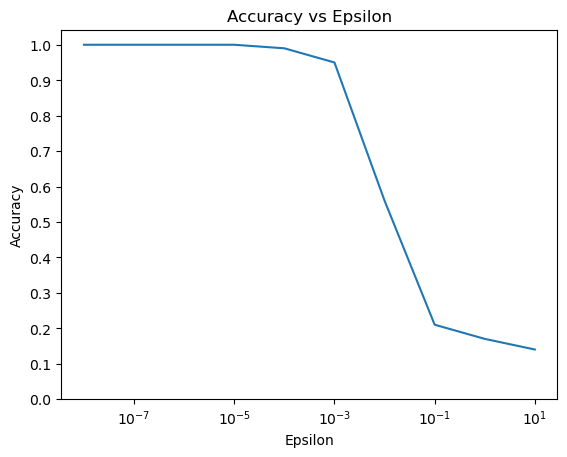

[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
{'1e-08': 1.0, '1e-07': 1.0, '1e-06': 1.0, '1e-05': 1.0, '0.0001': 0.99, '0.001': 0.95, '0.01': 0.56, '0.1': 0.21, '1.0': 0.17, '10.0': 0.14}


In [24]:
import matplotlib.pyplot as plt
# keys rounded to 4 decimal places
keys = [round(float(key),8) for key in scores.keys()]
plt.plot(keys, list(scores.values()))
plt.xscale('log')
plt.xlabel('Epsilon')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon')
# add ticks to the x axis

plt.show()
# plot the accuracy for each epsilon
print(keys)
print(scores)

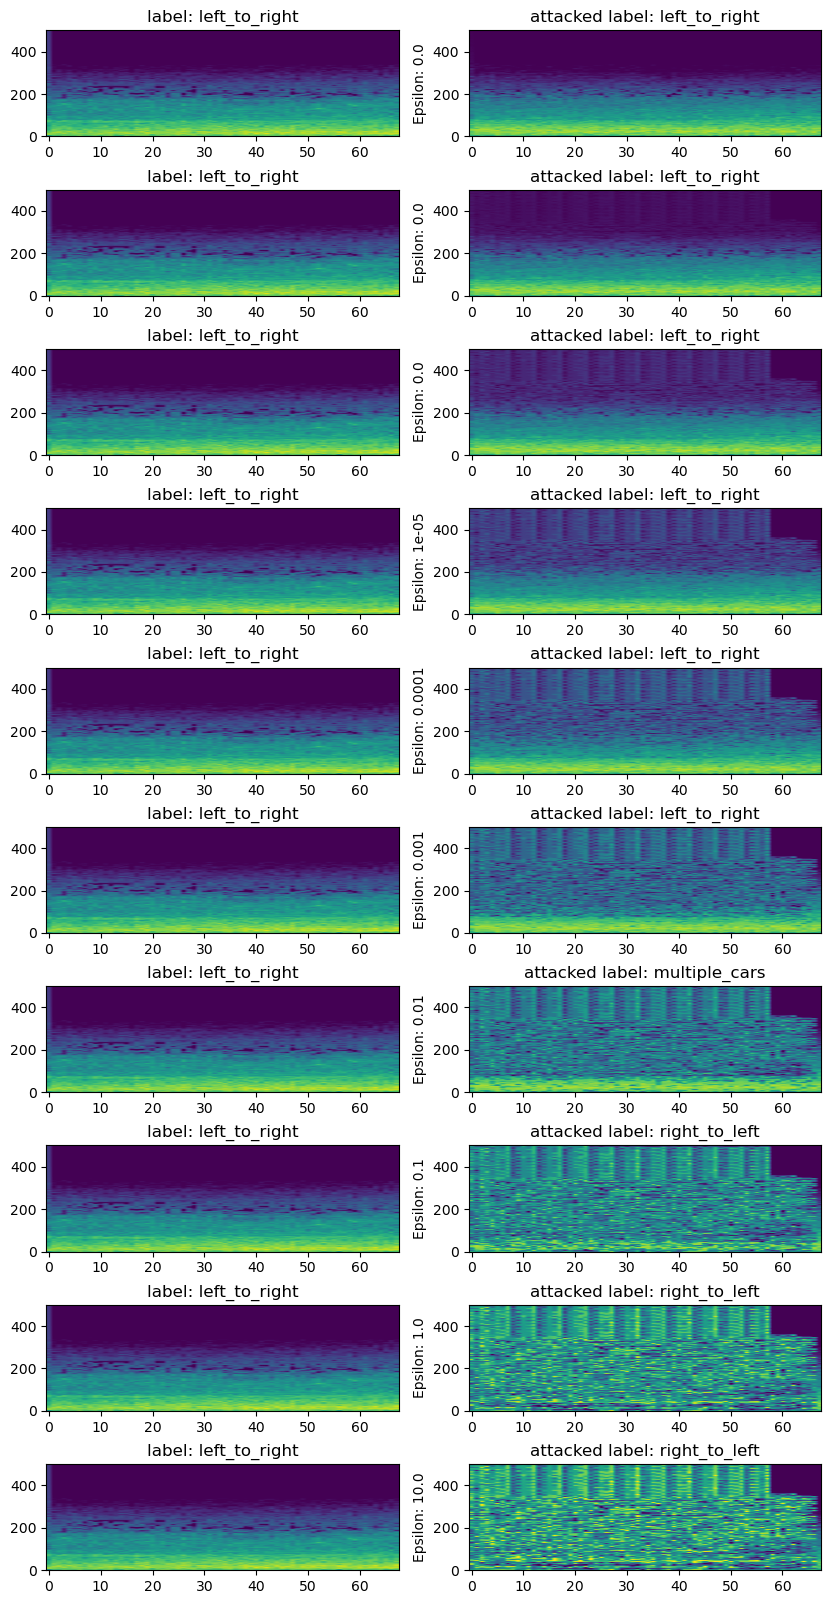

In [26]:
# plot all the base spectrograms and the perturbed spectrograms in a grid
import matplotlib.pyplot as plt
import librosa
plot_number = 10
fig, axs = plt.subplots(plot_number, 2, figsize=(10, 20))
step = len(plots_base)//plot_number
# add vertical spacing between the plots
fig.subplots_adjust(hspace = 0.5)
for i in range(0,len(plots_base),step):
    axs[i//step, 0].imshow(librosa.power_to_db(plots_base[i]), origin="lower", aspect="auto")
    axs[i//step, 1].imshow(librosa.power_to_db(plots_perturbed[i]), origin="lower", aspect="auto")
    axs[i//step, 0].set_title("label: " + label_base[i])
    axs[i//step, 1].set_title("attacked label: " +label_perturbed[i])
    axs[i//step, 1].set_ylabel("Epsilon: " + str(round(l[i],5)))



plt.show()


In [28]:
import numpy as np
import soundfile as sf

#sf.write('stereo_file.wav', np.random.randn(10, 2), 44100, 'PCM_24')

spectrogram = plots_perturbed[:-1]
print(spectrogram)

#Per your code you could try:
#sf.write('test.wav', audio_signal, sample_rate, 'PCM_24')

[array([[5.54432254e-03, 1.35522729e-04, 9.90442117e-04, ...,
        1.49027421e-03, 6.72126771e-05, 4.29507578e-03],
       [5.60081843e-03, 5.45243034e-04, 2.68618483e-02, ...,
        2.74732895e-03, 1.17220974e-03, 1.49420714e-02],
       [5.36069041e-04, 3.70011199e-03, 6.67719031e-03, ...,
        1.73100401e-02, 5.62706077e-03, 7.03959819e-03],
       ...,
       [1.29381874e-07, 0.00000000e+00, 0.00000000e+00, ...,
        6.09090486e-11, 7.41495337e-11, 1.25531363e-10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.13873452e-10, 1.35984460e-10, 2.90924619e-12],
       [0.00000000e+00, 1.00002936e-07, 1.00000669e-07, ...,
        5.27882148e-11, 1.26384241e-13, 2.08358539e-11]], dtype=float32), array([[5.5443225e-03, 1.3552273e-04, 9.9044212e-04, ..., 1.4902742e-03,
        6.7212677e-05, 4.2950758e-03],
       [5.6008184e-03, 5.4524303e-04, 2.6861848e-02, ..., 2.7473290e-03,
        1.1722097e-03, 1.4942071e-02],
       [5.3556956e-04, 3.6996123e-03, 

['left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right', 'left_to_right']
['left_to_right', 'left_to_right', 'left_to_right', 'multiple_cars', 'right_to_left', 'right_to_left', 'right_to_left', 'right_to_left', 'right_to_left', 'right_to_left']


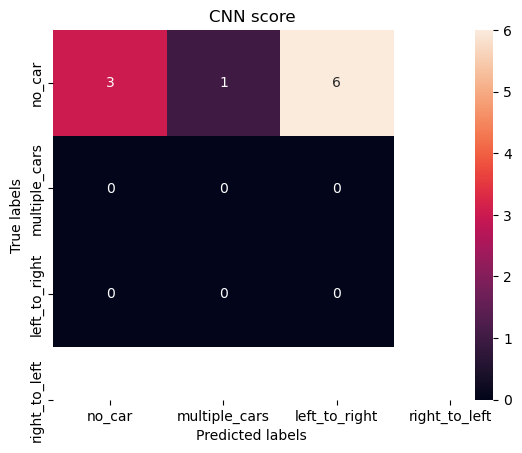

In [21]:
y_true = label_base
y_pred = label_perturbed
print(y_true)
print(y_pred)
from sklearn.metrics import confusion_matrix
import seaborn as sns
int_to_label = {0: 'no_car', 1: 'multiple_cars', 2: 'left_to_right', 3: 'right_to_left'}
cm = confusion_matrix(y_true, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, xticklabels=list(int_to_label.values()), yticklabels=list(int_to_label.values()), fmt='g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('CNN score')
plt.show()